In [1]:
import os
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import xesmf as xe
import xcdat as xc
import xsearch as xs
import xskillscore as xscore

from glob import glob 
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast

# Ignore xarray warnings (bad practice)
import warnings
warnings.simplefilter("ignore") 

In [13]:
# SANITY CHECK Plotting
def global_plot(data, lon, lat, cmap, pvalues=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = "", SAVE_PATH: str = ""):
    # plot map of global data with central longitude 180
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    img = ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # East Pacific South America
    # bound_region(ax1, lons=(-100, -70), lats=(-40, -10), color="black")
    bound_region(ax1, lons=(-105, -70), lats=(-40, -10), color="black")
    # bound_region(ax1, lons=(-95, -70), lats=(-40, -5), color="black")
    # Southern Ocean
    bound_region(ax1, lons=(-180, -75), lats=(-70, -50), color="black")
    # East Pacific
    # bound_region(ax1, lons=(-135, -80), lats=(-5, 5), color="black")
    # West Pacific
    bound_region(ax1, lons=(110, 165), lats=(-5, 5), color="black")
    
    # Draw triangular region
    # lat_min, lat_max = -40, 0
    # lon_min, lon_max = -180, -70
    # ax1.plot(
    #     [lon_min, lon_max, lon_max, lon_min], 
    #     [lat_max, lat_max, lat_min, lat_max], 
    #     color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    # )


    # Add Stippling
    if pvalues is not None:
        ax1.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(left_title, loc="left", fontweight="bold")
    ax1.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 45
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # Add a horizontal colorbar
    cbar = plt.colorbar(img, orientation='horizontal')
    cbar.set_label(cbar_label, fontsize=14)
    plt.savefig(f"figures/{SAVE_PATH}/{right_title}.png")

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

def get_triangle(tos, latmin, latmax, lonmin, lonmax, RES):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == ctos.shape[1]: break

        # print("j prior: ", j)
        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
            
        # print("j: ", j)
        nlats = int(len(latcoords) - j) # nlats below diag
        # print("nlats: ", nlats)
        ctos[:nlats, i] = np.full((nlats), np.nan) 
        
        jold = j
    
    return ctos


def get_triangle_mean(tos, latmin, latmax, lonmin, lonmax, RES):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ntime, nlat, nlon = tos.shape
    ctos = tos.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == ctos.shape[2]: break

        # print("j prior: ", j)
        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
            
        # print("j: ", j)
        nlats = int(len(latcoords) - j) # nlats below diag
        # print("nlats: ", nlats)
        ctos[:,:nlats, i] = np.full((ntime, nlats), np.nan) 
        
        jold = j
    
    return ctos
        


        



In [3]:
def remove_land_full(ds, var="skt"):
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.longitude, ds.latitude)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land

def fix_coords(data, include_T=True):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    if include_T: data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data


# Plot SST Trends

In [115]:
# era5 = xc.open_dataset("data/obs/ts_mon_ERA5_197901-202212.nc")
# print(era5)
# era5 = xc.open_dataset("data/obs/COBE2.sst.mon.mean.nc").sel(time=slice("1979-01-01", "2022-12-31"))
# print(era5)
# era5 = xc.open_dataset("data/obs/NOAA_ERSST_V5_sst.mnmean.nc").sel(time=slice("1979-01-01", "2022-12-31"))
# print(era5)
# ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST-2-2-0-0-0.nc").rename({"tos": "sst"})
# ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST.2.3.0.c_ensemble_member_001.nc").rename({"tos": "sst"})
# ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST_sst.nc")
# ds = xc.open_dataset("data/obs/COBE2.sst.mon.mean.nc")
ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2/sst.mnmean.nc")
# ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadSST/HadSST.4.0.1.0_median.nc").rename({"tos": "sst"})
ds
# ds = xc.open_dataset("/p/user_pub/work/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9/ocean/mon/tos/gn/v20230512/tos_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc").rename({"tos": "sst"})
# ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2/sst.mnmean.nc")

2023-08-29 16:19:47,817 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, time: 484, nbnds: 2, bnds: 2)
Coordinates:
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 1981-12-01 00:00:00 ... 2022-03-01 00:00:00
Dimensions without coordinates: nbnds, bnds
Data variables:
    sst        (time, lat, lon) float32 ...
    time_bnds  (time, nbnds) object ...
    lon_bnds   (lon, bnds) float32 0.0 1.0 1.0 2.0 ... 358.0 359.0 359.0 360.0
    lat_bnds   (lat, bnds) float32 90.0 89.0 89.0 88.0 ... -89.0 -89.0 -90.0
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Wed Apr  6 13:47:45 2005: ncks -d time,0,278 SAVEs/sst.mn...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

In [4]:
def load_sst(product_name="ERA5"):
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(-178.5, 180, 2.5)
    output_grid = xc.create_grid(lat, lon)
    
    # USE A COMMON TIME PERIOD 
    start_time = "1982-01-01"
    end_time = "2022-12-31"

    ###### PREPROCESSING ######
    if product_name == "ERA5":
        ds = xc.open_dataset("data/obs/ts_mon_ERA5_197901-202212.nc").rename({"skt": "sst"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "NOAA":
        ds = xc.open_dataset("data/obs/NOAA_ERSST_V5_sst.mnmean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
        
    elif product_name == "COBE":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/COBE/sst.mon.mean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    elif product_name == "COBE2":
        ds = xc.open_dataset("data/obs/COBE2.sst.mon.mean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
        
    elif product_name == "NOAA-OISST-v2.1":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2.1/sst.mon.mean.nc")
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "NOAA-OISST-v2.0":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2/sst.mnmean.nc")
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "HadISST-1.1":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST_sst.nc").sel(time=slice(start_time, end_time))

    # elif product_name == "HadISST-2.2":
    #     ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST-2-2-0-0-0.nc").rename({"tos": "sst"})
    #     ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    # elif product_name == "HadISST-2.3":
    #     ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST.2.3.0.c_ensemble_member_001.nc").rename({"tos": "sst"})
    #     ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    # elif product_name == "HadSST4":
    #     ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadSST/HadSST.4.0.1.0_median.nc").rename({"tos": "sst"}).sel(time=slice(start_time, end_time))

    elif product_name == "PCMDI-AMIP-1-1-9":
        ds = xc.open_dataset("/p/user_pub/work/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9/ocean/mon/tos/gn/v20230512/tos_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc").rename({"tos": "sst"})
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
    
    ###### PREPROCESSING ######
    ds = remove_land_full(ds, var="sst").rename("sst").to_dataset()
    ds = fix_coords(ds, include_T=True)
    ds = ds.reindex(latitude=list(reversed(ds.latitude)))
    # Calculate Anomalies
    ds = ds.temporal.departures("sst", "month")
    # Regrid to 2.5x2.5 degree grid
    ds = ds.regridder.horizontal("sst", output_grid, tool='xesmf', method='bilinear')
    ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    # Get SST Trend in Triangular Region
    latmin, latmax = -38.75, -1.25
    lonmin, lonmax = -178.75, -71.25
    RES = 2.5
    ept = get_triangle_mean(ds["sst"].copy(), latmin, latmax, lonmin, lonmax, RES)
    # print(ept)
    ept_mean  = (fix_coords(ept.rename("tos").to_dataset(), include_T=False)).spatial.average("tos")["tos"]
    # EPT Trend
    from scipy.stats import linregress
    time_idx = xr.DataArray(np.arange(len(ds.time)), dims=("time"))
    reg = linregress(time_idx, ept_mean)
    # print(reg.slope*12*30)
    ept_mean_trend = xscore.linslope(time_idx, ept_mean, dim="time")*12*30
    # print(ept_mean_trend)


    # Get SST Trends
    time_idx = xr.DataArray(np.arange(len(ds.time)), dims=("time"))
    ds_trends = xscore.linslope(time_idx, ds["sst"], dim="time")*12*30
    ds_sig = xscore.pearson_r_p_value(time_idx, ds["sst"], dim="time")

    # Get SST Trend in Triangular Region
    ept = get_triangle(ds_trends.copy(), latmin, latmax, lonmin, lonmax, RES)
    # print(ept)
    EPT_mean_trend = (fix_coords(ept.rename("tos").to_dataset(), include_T=False)).spatial.average("tos")["tos"]
    # print(EPT_mean_trend)

    # Sanity Check - Plot ERA5 SST Trends
    global_plot(
        ds_trends,
        ds_trends.longitude, 
        ds_trends.latitude, 
        pvalues=ds_sig, 
        levels=np.arange(-1,1.1,.1), 
        cmap="RdBu_r", 
        left_title=f"{np.around(ept_mean_trend.values, 3)}", 
        right_title=f"{product_name}",
        cbar_label=r"$K/30yr$",
        SAVE_PATH="SST_Trends",
    )

    return ds_trends, ds_sig, ept_mean_trend, ds

For each latitude step of 2.5 degrees, longitude step is 7.5


2023-09-05 10:14:28,369 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5
For each latitude step of 2.5 degrees, longitude step is 7.5


2023-09-05 10:14:36,862 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5
For each latitude step of 2.5 degrees, longitude step is 7.5


2023-09-05 10:14:40,373 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


2023-09-05 10:14:41,486 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


For each latitude step of 2.5 degrees, longitude step is 7.5


2023-09-05 10:14:43,933 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


2023-09-05 10:14:44,677 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


For each latitude step of 2.5 degrees, longitude step is 7.5


2023-09-05 10:14:51,792 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5
For each latitude step of 2.5 degrees, longitude step is 7.5


2023-09-05 10:16:46,370 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


2023-09-05 10:16:47,838 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


For each latitude step of 2.5 degrees, longitude step is 7.5


2023-09-05 10:16:53,465 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5


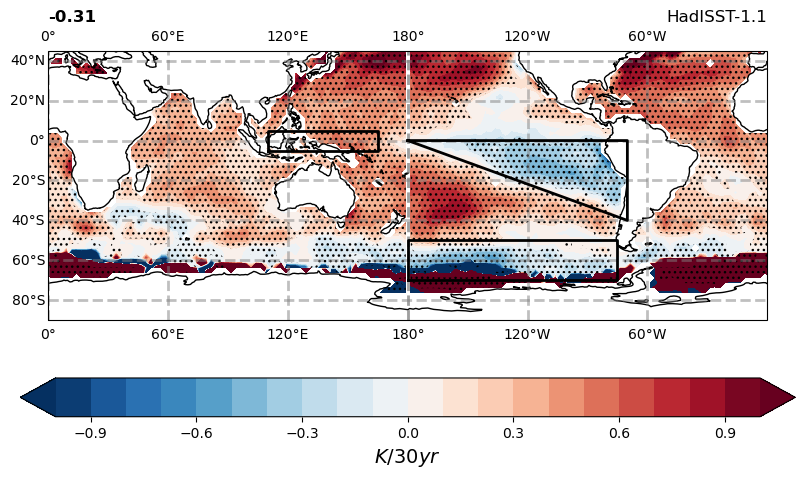

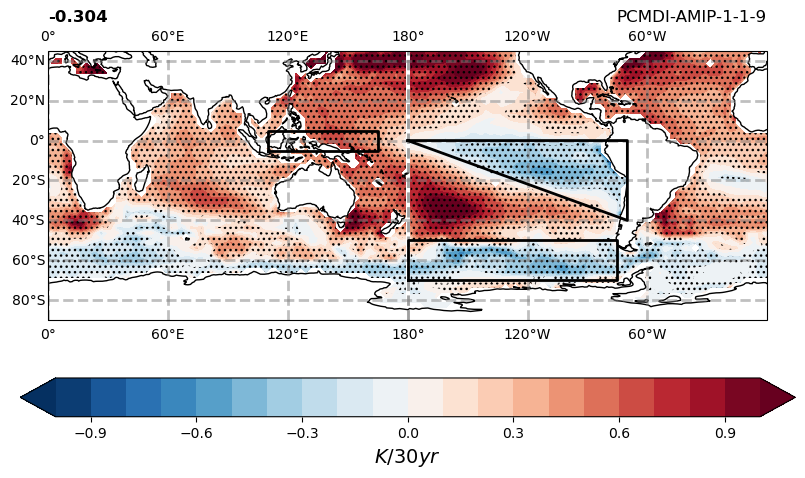

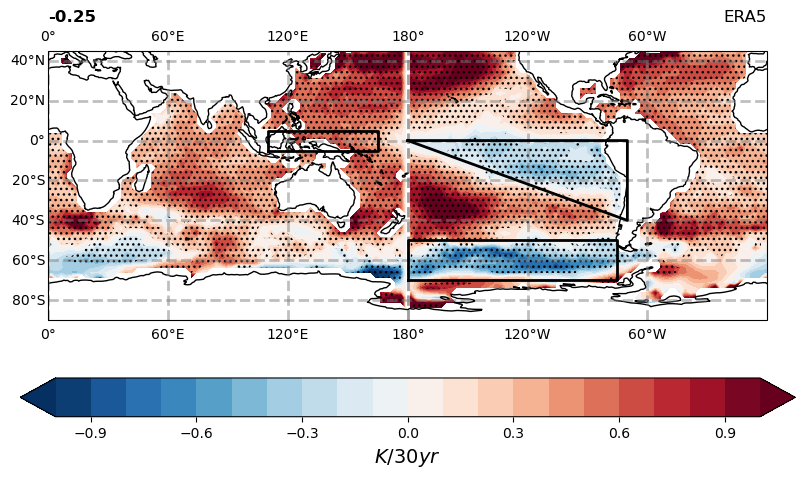

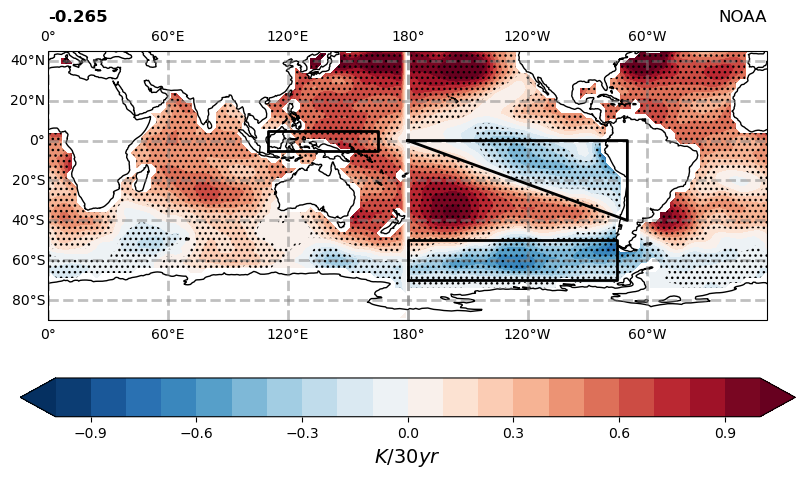

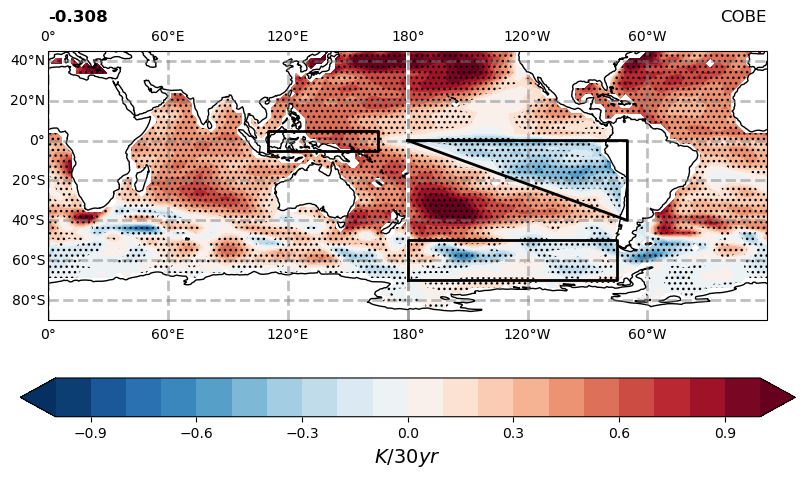

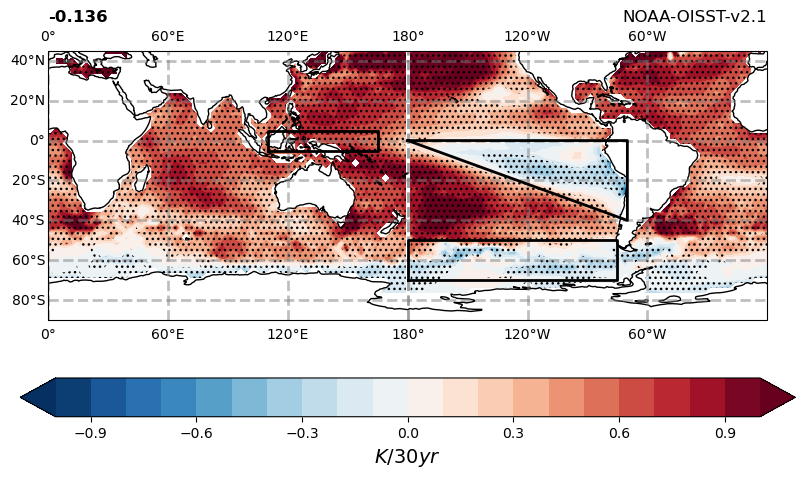

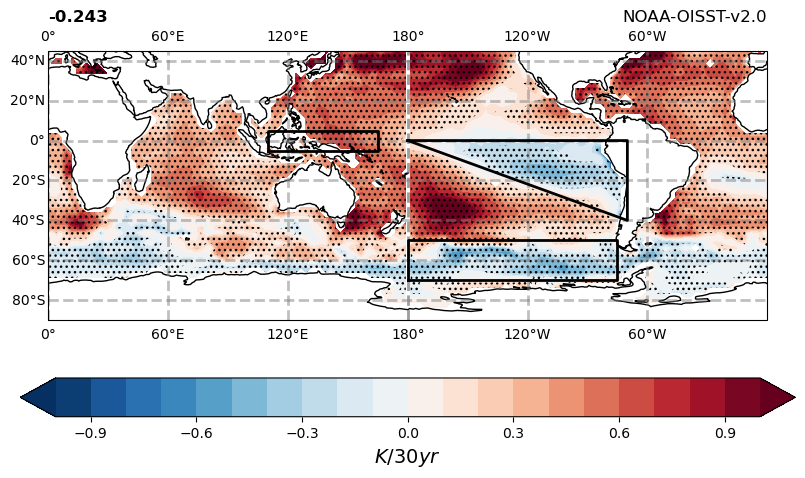

In [7]:
# SST_PRODUCTS = ["ERA5", "NOAA", "COBE", "COBE2", "NOAA-OISST-v2.1", "NOAA-OISST-v2.0", "HadISST-1.1", "HadSST4", "PCMDI-AMIP-1-1-9"]
SST_PRODUCTS = ["HadISST-1.1", "PCMDI-AMIP-1-1-9", "ERA5", "NOAA", "COBE", "NOAA-OISST-v2.1", "NOAA-OISST-v2.0"]

sst_trends = {}
sst_sig = {}
sst_ept_mean = {}
sst_ds = {}
for sst_product in SST_PRODUCTS: 
    trends, sig, mean, ssts = load_sst(sst_product)
    sst_trends[sst_product] = trends
    sst_sig[sst_product] = sig
    sst_ept_mean[sst_product] = mean
    sst_ds[sst_product] = ssts

In [8]:
sst_ept_mean_trends = np.array([a.values for a in sst_ept_mean.values()])
print(np.mean(sst_ept_mean_trends), sst_ept_mean_trends)

# np.mean([-0.30995762, -0.30437485, -0.21955642, -0.26466877, -0.30762401, -0.03324401, -0.13590471, -0.24306433])

-0.25930445921074835 [-0.30995762 -0.30437485 -0.24953692 -0.26466877 -0.30762401 -0.13590471
 -0.24306433]


# Load SST Anaylsis - Useful for Reference

2023-08-23 15:04:20,190 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray (latitude: 19, longitude: 54)>
array([[ 1.90507039e-03,  1.48479773e-03,  2.19576826e-03, ...,
        -2.53449736e-04, -1.73712776e-03,             nan],
       [ 1.15427820e-03,  1.92367206e-03,  1.83455536e-03, ...,
        -5.61894537e-04, -6.88950062e-04,             nan],
       [ 1.79484969e-03,  1.97094802e-03,  1.98399150e-03, ...,
        -1.00110074e-03, -4.46387732e-04, -2.18059740e-03],
       ...,
       [ 3.52934177e-04,  1.83412803e-04,  1.70951063e-04, ...,
                    nan,             nan,             nan],
       [-6.88118637e-05, -3.84437866e-05, -2.13521237e-04, ...,
                    nan,             nan,             nan],
       [-8.34016406e-05, -2.00467018e-04, -1.42950260e-04, ...,
                    nan,             nan,             nan]])
Coordinates:
  * latitude   (latitude) float32 -38.0 -36.0 -34.0 -32.0 ... -6.0 -4.0 -2.0
  * longitude  (longitude) float32 -178.0 -

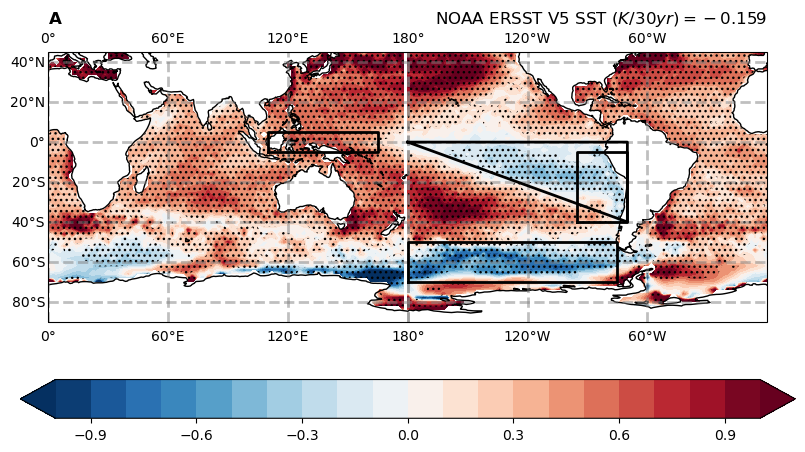

In [69]:
era5 = xc.open_dataset("data/obs/ts_mon_ERA5_197901-202212.nc")
# era5 = xc.open_dataset("data/obs/COBE2.sst.mon.mean.nc").sel(time=slice("1979-01-01", "2022-12-31"))
# era5 = xc.open_dataset("data/obs/NOAA_ERSST_V5_sst.mnmean.nc").sel(time=slice("1979-01-01", "2022-12-31"))
# era5 = era5.rename({"lon": "longitude", "lat": "latitude", "sst": "skt"})

era5 = remove_land_full(era5, var="skt")
era5_ds = fix_coords(era5.to_dataset()) #- 273.15)
era5_ds = era5_ds.temporal.departures("skt", "month")

time_idx = xr.DataArray(np.arange(len(era5_ds.time)), dims=("time"))
era5_trends = xscore.linslope(time_idx, era5_ds["skt"], dim="time")
era5_sig = xscore.pearson_r_p_value(time_idx, era5_ds["skt"], dim="time")

# Get SST Trend in Triangular Region
latmin, latmax = -38.75, -1.25
lonmin, lonmax = -178.75, -71.25
RES = 2.5
    
era5_reindex = era5_trends.reindex(latitude=list(reversed(era5_trends.latitude)))
ept = get_triangle(era5_reindex, latmin, latmax, lonmin, lonmax, RES)*12*30
EPT_mean_trend = (fix_coords(ept.rename("tos").to_dataset(), include_T=False)).spatial.average("tos")["tos"]

# Plot ERA5 SST Trends
global_plot(
    era5_trends*12*30, 
    era5_trends.longitude, 
    era5_trends.latitude, 
    pvalues=era5_sig, 
    levels=np.arange(-1,1.1,.1), 
    cmap="RdBu_r", 
    left_title="A", 
    right_title=f"NOAA ERSST V5 SST $(K/30yr) = {np.around(EPT_mean_trend.values, 3)}$"
)
# global_plot(era5_trends, era5_trends.longitude, era5_trends.latitude, pvalues=era5_sig, levels=np.arange(-1,1.1,.1), cmap="RdBu_r", left_title="B", right_title="ERA5 $\Delta$SST $(K/30yr)$")

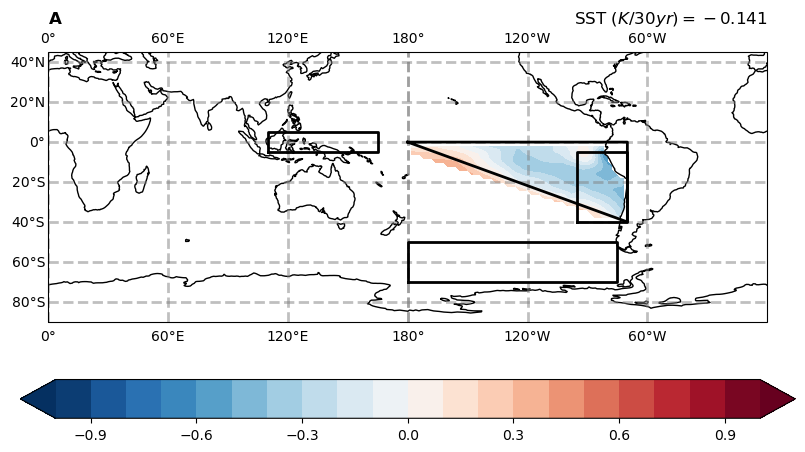

In [38]:

global_plot(
    data=ept,
    lat=ept.lat,
    lon=ept.lon,
    pvalues=None, 
    levels=np.arange(-1, 1.1, .1),
    cmap="RdBu_r",
    left_title="A", 
    right_title=f" SST $(K/30yr) = {np.around(EPT_mean_trend.values, 3)}$"
)

In [16]:
era5_ds = fix_coords(era5.to_dataset() - 273.15)
era5_ds = era5_ds.temporal.departures("skt", "month")


era5_westPacificHoell = era5_ds.sel(longitude=slice(130, 150), latitude=slice(10, 0)).spatial.average("skt")["skt"]
era5_eastPacificObs = era5_ds.sel(longitude=slice(-180, -80), latitude=slice(0, -10)).spatial.average("skt")["skt"]
era5_WE = era5_westPacificHoell - era5_eastPacificObs
    

era5_westPacificWills = era5_ds.sel(longitude=slice(110, 165), latitude=slice(5, -5)).spatial.average("skt")["skt"]
era5_eastPacificWills = era5_ds.sel(longitude=slice(-135, -80), latitude=slice(5, -5)).spatial.average("skt")["skt"]
era5_WE = era5_westPacificWills - era5_eastPacificWills

era5_eastPacificSA = era5_ds.sel(longitude=slice(-95, -70), latitude=slice(-5, -40)).spatial.average("skt")["skt"]

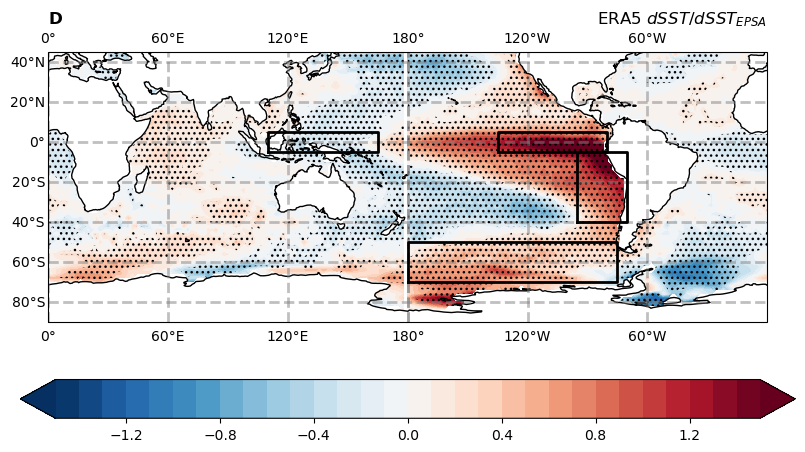

In [9]:
dsst_dsstWE = xscore.linslope(era5_eastPacificSA, era5_ds["skt"], dim="time", skipna=True)
dsst_dsstWE_pvalue = xscore.pearson_r_p_value(era5_eastPacificSA, era5_ds["skt"], dim="time", skipna=True)
global_plot(dsst_dsstWE, dsst_dsstWE.longitude, dsst_dsstWE.latitude, pvalues=dsst_dsstWE_pvalue, levels=np.arange(-1.5,1.6, .1), cmap="RdBu_r", left_title="D", right_title=r"ERA5 $dSST/dSST_{EPSA}$")

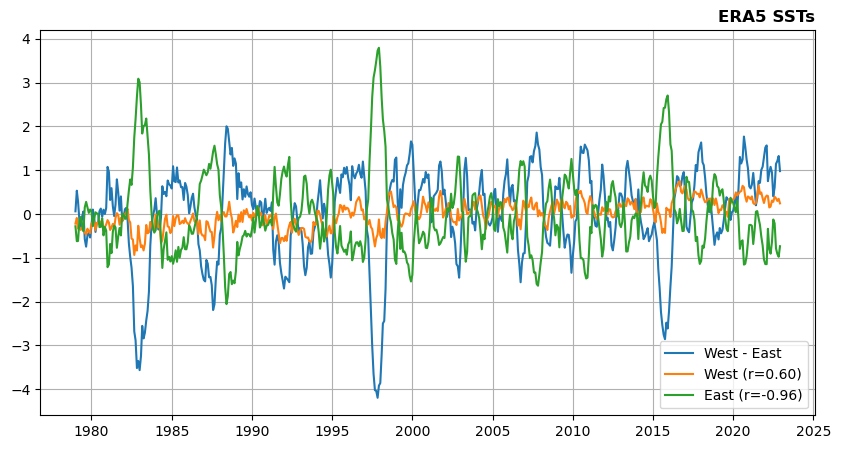

In [56]:
from scipy.stats import linregress

plt.plot(np.arange("1979-01", "2023-01", dtype="datetime64[M]"), era5_WE, label="West - East")
res = linregress(era5_westPacificWills, era5_WE)
plt.plot(np.arange("1979-01", "2023-01", dtype="datetime64[M]"), era5_westPacificWills, label=f"West (r={res.rvalue:.2f})")
res = linregress(era5_eastPacificWills, era5_WE)
plt.plot(np.arange("1979-01", "2023-01", dtype="datetime64[M]"), era5_eastPacificWills, label=f"East (r={res.rvalue:.2f})")
plt.legend()
plt.grid()
plt.title("ERA5 SSTs", fontweight="bold", loc="right")
# set size
fig = plt.gcf()
fig.set_size_inches(10, 5)

# Plot SWCRE Trends and Calculate SWCF

In [9]:
def remove_land(ds, var="skt"):
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.lon, ds.lat)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land


In [10]:
# Load SWCRE Observations
ceres = xc.open_dataset("data/obs/CERES_EBAF-TOA_Ed4.1_Subset_200003-202201.nc")
swas = remove_land(ceres, var="toa_sw_all_mon")
swcs = remove_land(ceres, var="toa_sw_clr_c_mon")
swcre = swcs - swas # Clear Sky minus All Sky

## REGRID SWCRE
lat = np.arange(-88.75, 90, 2.5)
lon = np.arange(-178.5, 180, 2.5)
output_grid = xc.create_grid(lat, lon)

swcre_ds = fix_coords(swcre.rename("swcre").to_dataset())
swcre_regrid = swcre_ds.regridder.horizontal("swcre", output_grid, tool='xesmf', method='bilinear')
swcre_regrid["time"] = np.arange("2000-03-01", "2022-02", dtype="datetime64[M]")
swcre_regrid = swcre_regrid.rename({"lon": "longitude", "lat": "latitude"})

# Calculate Anomalies
swcre_regrid = fix_coords(swcre_regrid, include_T=True).temporal.departures("swcre", "month")
swcre_regrid

2023-09-05 10:16:57,761 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


2023-09-05 10:17:00,379 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-09-05 10:17:00,386 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.


<xarray.Dataset>
Dimensions:    (time: 263, latitude: 72, longitude: 144, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2000-03-01 2000-04-01 ... 2022-01-01
  * latitude   (latitude) float64 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float64 -178.5 -176.0 -173.5 ... 174.0 176.5 179.0
Dimensions without coordinates: bnds
Data variables:
    swcre      (time, latitude, longitude) float64 nan nan ... -1.49e-08
    lat_bnds   (latitude, bnds) float64 -90.0 -87.5 -87.5 ... 87.5 87.5 90.0
    lon_bnds   (longitude, bnds) float64 -179.8 -177.2 -177.2 ... 177.8 -179.8
    time_bnds  (time, bnds) datetime64[ns] 2000-02-14T12:00:00 ... 2022-01-16...

2023-09-05 10:20:13,821 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2023-09-05 10:20:16,156 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2023-09-05 10:20:18,427 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2023-09-05 10:20:20,262 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2023-09-05 10:20:22,516 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2023-09-05 10:20:24,580 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assum

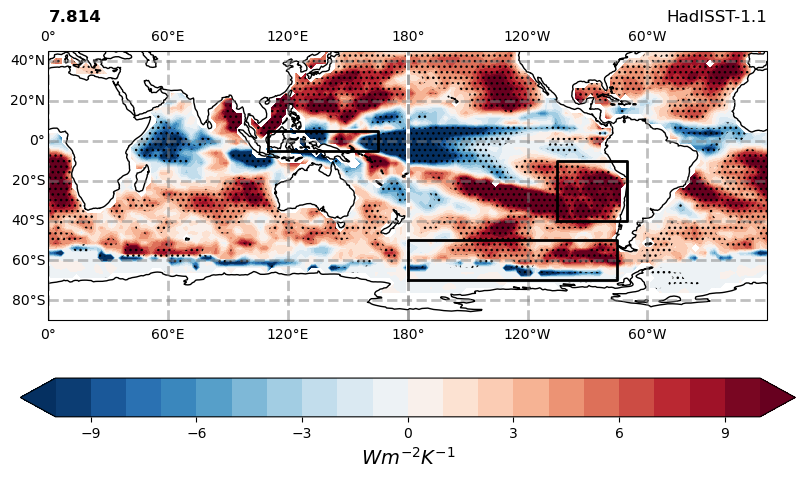

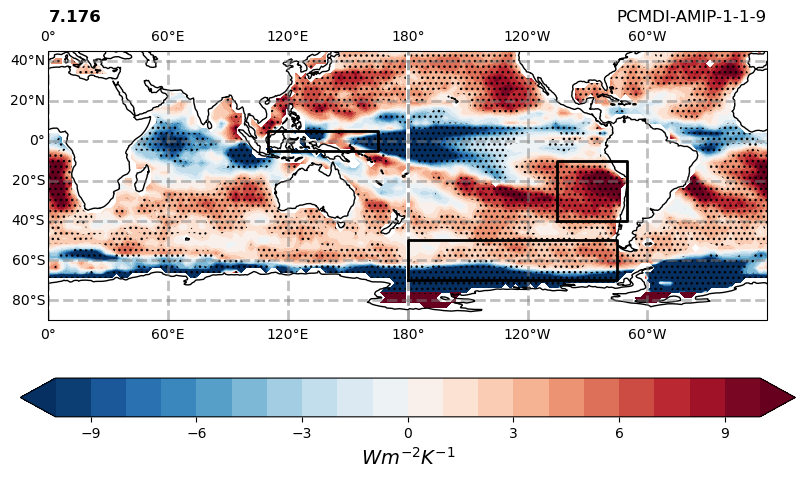

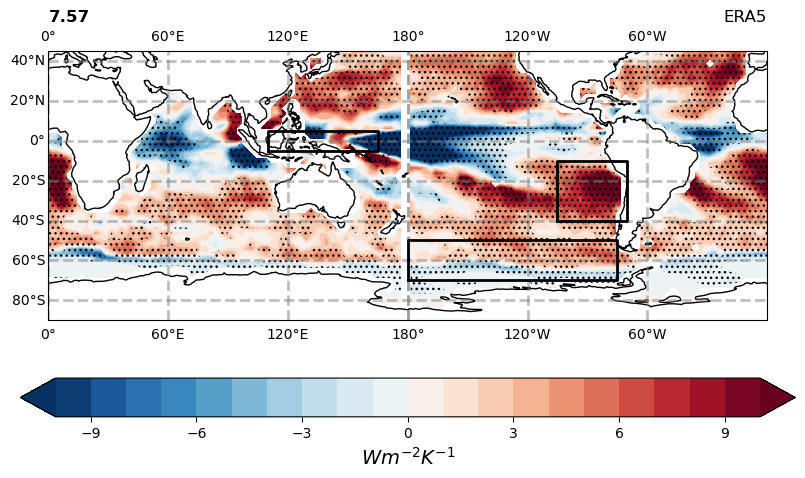

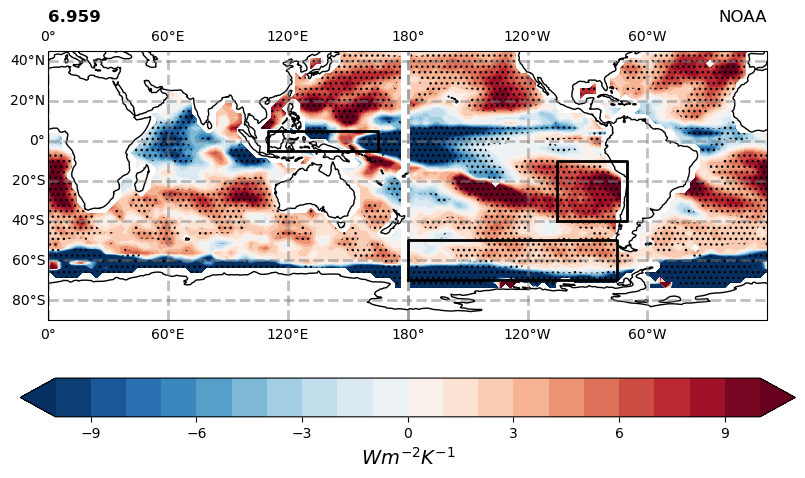

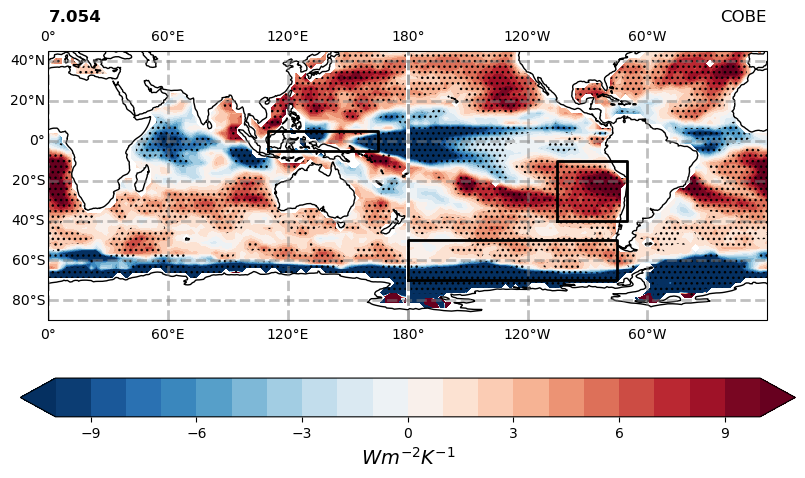

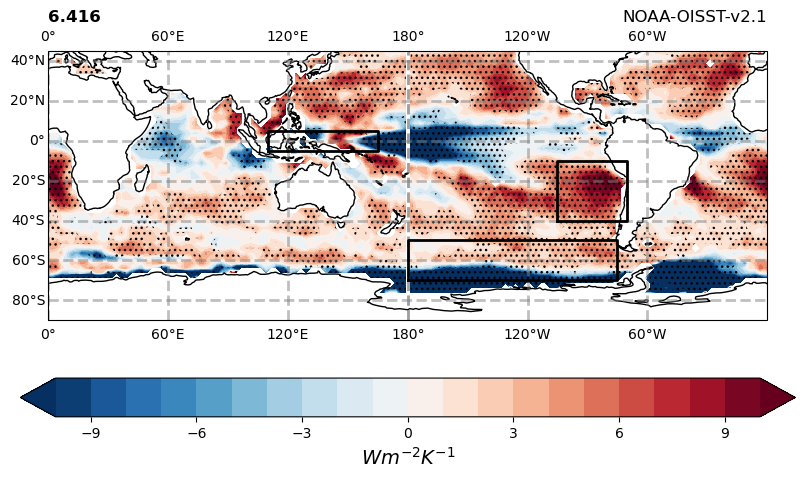

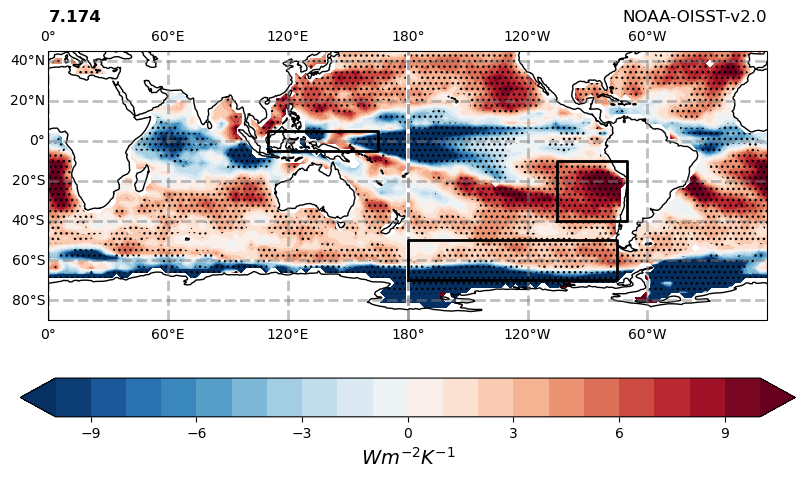

In [14]:
swcfs = {}
for (product, ssts) in sst_ds.items():
    if product == "NOAA-OISST-v2.0": 
        ssts["time"] = np.arange("1982-01-01", "2022-04-01", dtype="datetime64[M]")
    else:
        ssts["time"] = np.arange("1982-01-01", "2023-01-01", dtype="datetime64[M]")
    ssts = ssts["sst"].sel(time=swcre_regrid.time)
    dcredsst = xscore.linslope(ssts, swcre_regrid["swcre"], dim="time", skipna=True)
    dcredsst_pvalue = xscore.pearson_r_p_value(ssts, swcre_regrid["swcre"], dim='time', skipna=True)

    dcredsst = fix_coords(dcredsst.rename("swcf").to_dataset(), include_T=False)
    swcf_epsa = dcredsst.sel(longitude=slice(-100, -70), latitude=slice(-40, -10)).spatial.average("swcf")["swcf"]
    swcfs[product] = swcf_epsa

    global_plot(dcredsst["swcf"], dcredsst.longitude, dcredsst.latitude, 
                levels=np.arange(-10, 11, 1), 
                pvalues=dcredsst_pvalue, 
                cmap="RdBu_r", 
                left_title=f"{np.around(swcf_epsa.values, 3)}", 
                right_title=f"{product}",
                cbar_label=r"$Wm^{-2}K^{-1}$",
                SAVE_PATH="SWCF_SX")


In [16]:
print("Multimodel Mean: ", np.mean(np.array([a.values for a in swcfs.values()])))
np.array([a.values for a in swcfs.values()])

Multimodel Mean:  7.166103127947261


array([7.81434168, 7.17606042, 7.57042384, 6.95852917, 7.05380873,
       6.41551741, 7.17404065])

# Plow CRE Trends

2023-08-09 09:33:24,202 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


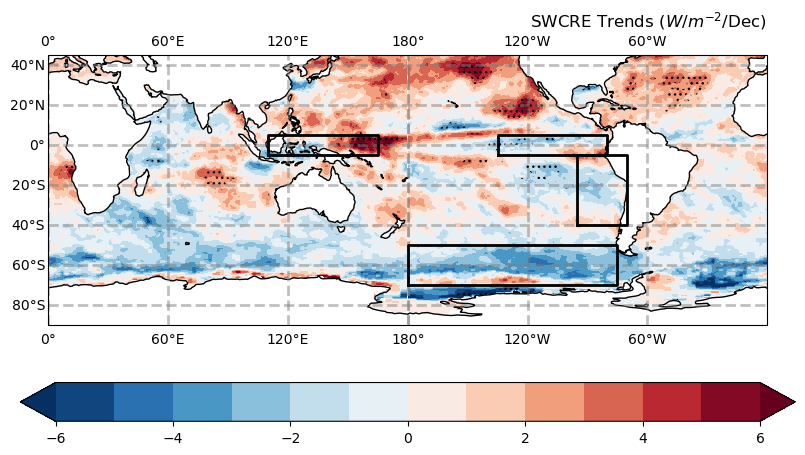

In [40]:
ceres = xc.open_dataset("data/obs/CERES_EBAF-TOA_Ed4.1_Subset_200003-202201.nc")
swas = remove_land(ceres, var="toa_sw_all_mon")
swcs = remove_land(ceres, var="toa_sw_clr_c_mon")
swcre = swcs - swas # Clear Sky minus All Sky

time_idx = xr.DataArray(np.arange(len(swcre.time)), dims=("time"))
swcre_trends = xscore.linslope(time_idx, swcre, dim="time")*12*10
swcre_sig = xscore.pearson_r_p_value(time_idx, swcre, dim="time")

# Plot ERA5 SST Trends
global_plot(swcre_trends, swcre_trends.lon, swcre_trends.lat, pvalues=swcre_sig, levels=np.arange(-6, 7, 1), cmap="RdBu_r", right_title=r"SWCRE Trends ($W/m^{-2}$/Dec)")

2023-08-07 10:52:50,477 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


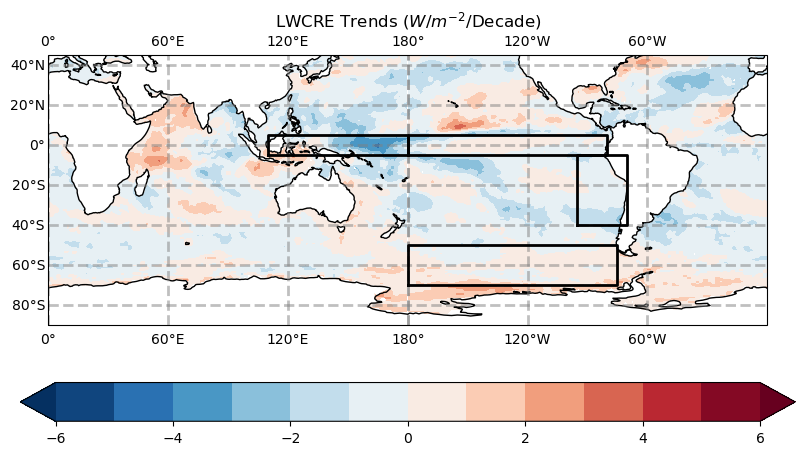

In [49]:
ceres = xc.open_dataset("data/obs/CERES_EBAF-TOA_Ed4.1_Subset_200003-202201.nc")
lwas = remove_land(ceres, var="toa_lw_all_mon")
lwcs = remove_land(ceres, var="toa_lw_clr_c_mon")
lwcre = lwcs - lwas # Clear Sky minus All Sky

time_idx = xr.DataArray(np.arange(len(lwcre.time)), dims=("time"))
lwcre_trends = xscore.linslope(time_idx, lwcre, dim="time")*12*10

# Plot ERA5 SST Trends
global_plot(lwcre_trends, lwcre_trends.lon, lwcre_trends.lat, levels=np.arange(-6, 7, 1), cmap="RdBu_r", title=r"LWCRE Trends ($W/m^{-2}$/Decade)")

2023-08-07 16:31:44,910 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


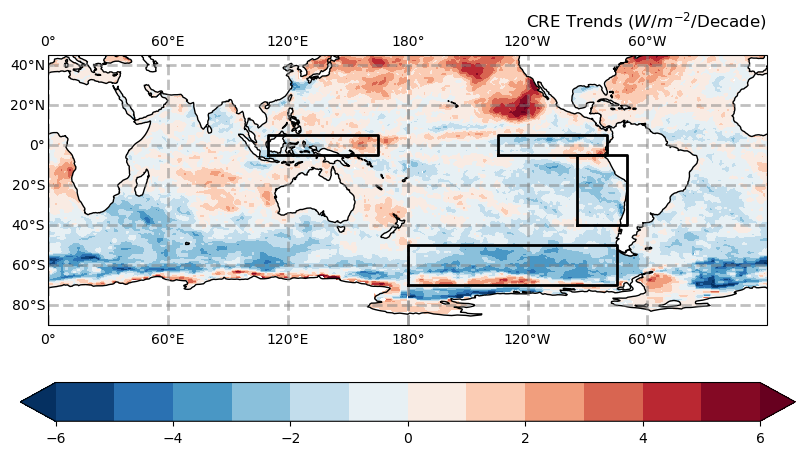

In [101]:
ceres = xc.open_dataset("data/obs/CERES_EBAF-TOA_Ed4.1_Subset_200003-202201.nc")
nas = remove_land(ceres, var="toa_net_all_mon")
ncs = remove_land(ceres, var="toa_net_clr_c_mon")
cre = -(ncs - nas) # Clear Sky minus All Sky (These are both incoming/downard fluxes, so we need to flip the sign)

time_idx = xr.DataArray(np.arange(len(cre.time)), dims=("time"))
cre_trends = xscore.linslope(time_idx, cre, dim="time")*12*10

# Plot ERA5 SST Trends
global_plot(cre_trends, cre_trends.lon, cre_trends.lat, levels=np.arange(-6, 7, 1), cmap="RdBu_r", right_title=r"CRE Trends ($W/m^{-2}$/Decade)")

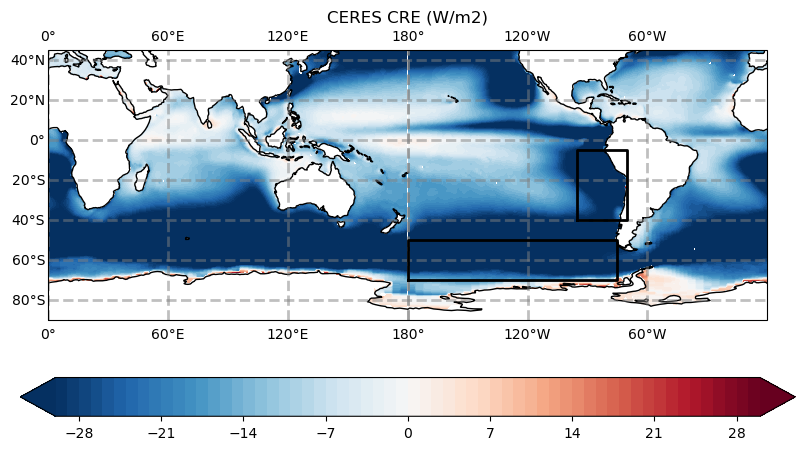

In [39]:
global_plot(cre.mean("time"), cre.lon, cre.lat, levels=np.arange(-30, 31, 1), cmap="RdBu_r", title="CERES CRE (W/m2)")

# Plot EIS Trends

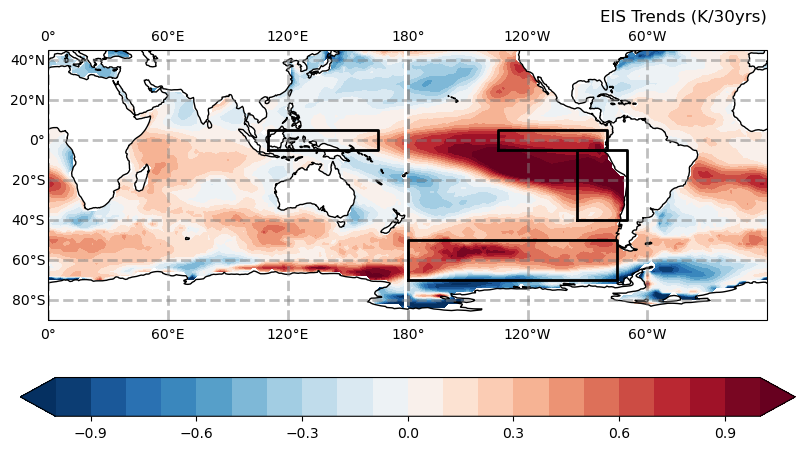

In [12]:
eis = xc.open_dataset("data/obs/EIS_mon_197901-202212_obs.nc")
eis = remove_land_full(eis, var="eis")

time_idx = xr.DataArray(np.arange(len(eis.time)), dims=("time"))
eis_trends = xscore.linslope(time_idx, eis, dim="time")*12*30

# Plot ERA5 SST Trends
global_plot(eis_trends, eis_trends.longitude, eis_trends.latitude, levels=np.arange(-1,1.1,.1), cmap="RdBu_r", right_title="EIS Trends (K/30yrs)")

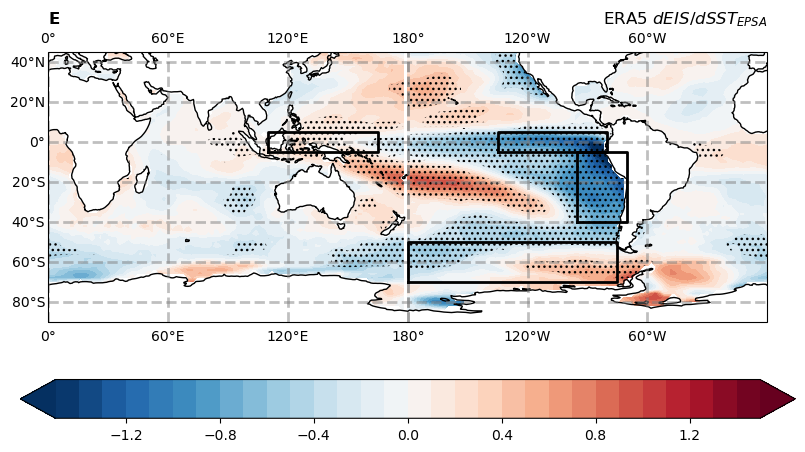

In [14]:
deis_dsstWE = xscore.linslope(era5_eastPacificSA, eis, dim="time", skipna=True)
deis_dsstWE_pvalue = xscore.pearson_r_p_value(era5_eastPacificSA, eis,dim="time", skipna=True)
global_plot(deis_dsstWE, deis_dsstWE.longitude, deis_dsstWE.latitude, pvalues=deis_dsstWE_pvalue, levels=np.arange(-1.5,1.6, .1), cmap="RdBu_r", left_title="E", right_title=r"ERA5 $dEIS/dSST_{EPSA}$")

# Plot dsst/dcre

In [41]:
cre = swcre
# era5_WE = era5_eastPacificSA

def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

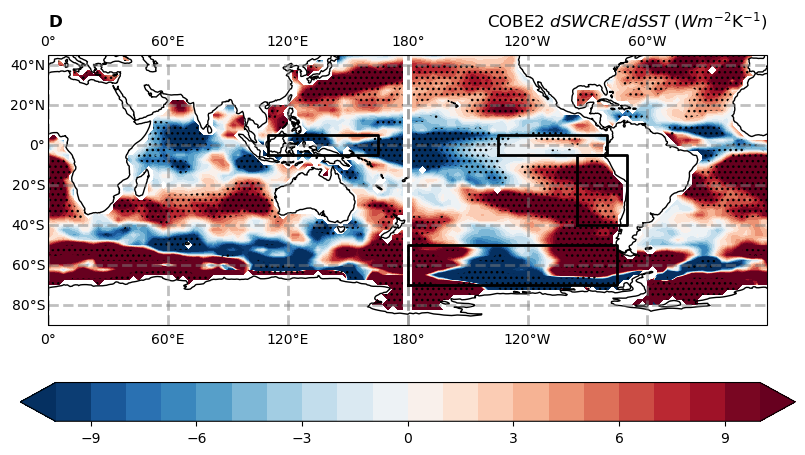

In [207]:
# lat = np.arange(-88.75, 90, 2.5)
# lon = np.arange(-178.75, 180, 2.5)
lat = np.arange(-90, 90, 2.5)
lon = np.arange(-180, 180, 2.5)
output_grid = xc.create_grid(lat, lon)

# Regrid Data
era5_reindex = era5_ds.reindex(latitude=list(reversed(era5.latitude)))
era5_regrid = era5_ds.regridder.horizontal("skt", output_grid, tool='xesmf', method='bilinear')
cre_ds = fix_coords(cre.rename("cre").to_dataset())
cre_regrid = cre_ds.regridder.horizontal("cre", output_grid, tool='xesmf', method='bilinear')

# cre_regrid["time"] = np.arange("2000-03", "2022-02", dtype="datetime64[M]")
cre_regrid = cre_regrid.sel(time=slice("2000-03", "2019-12"))
cre_regrid["time"] = np.arange("2000-03", "2020-01", dtype="datetime64[M]")
era5_regrid = era5_regrid.sel(time=cre_regrid.time)
era5_regrid["time"] = cre_regrid.time

dcredsst = xscore.linslope(era5_regrid["skt"], cre_regrid["cre"], dim="time", skipna=True)
dcredsst_pvalue = xscore.pearson_r_p_value(era5_regrid["skt"], cre_regrid["cre"], dim='time', skipna=True)

global_plot(dcredsst, dcredsst.lon, dcredsst.lat, levels=np.arange(-10, 11, 1), pvalues=dcredsst_pvalue, cmap="RdBu_r", left_title="D", right_title=r"COBE2 $dSWCRE/dSST$ ($Wm^{-2}$K$^{-1}$)")

In [42]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data
    
# ds = fix_coords(dcredsst.rename("swcf").to_dataset())
# ds.sel(lon=slice(-95, -70), lat=slice(-40,-5)).spatial.average("swcf")["swcf"] # Observed definition 

In [43]:
cre["time"] = np.arange("2000-03", "2022-02", dtype="datetime64[M]")
era5_eastPacificSA = era5_eastPacificSA.sel(time=cre.time)
era5_eastPacificSA["time"] = cre.time

# cre = cre.resample(time="6M").mean()
# era5_WE_c = era5_WE_c.resample(time="6M").mean()
# dsstwedcre = xscore.linslope(cre, era5_WE_c, dim="time", skipna=True)

# Standardize
# cre = (cre - cre.mean("time")) / cre.std("time")
# era5_WE_c = (era5_WE_c - era5_WE_c.mean("time")) / era5_WE_c.std("time")

dsstwedcre = xscore.linslope(era5_eastPacificSA, cre, dim="time", skipna=True)
dsstwedcre_p = xscore.pearson_r_p_value(era5_eastPacificSA, cre, dim='time', skipna=True)
dsstwedcre = fix_coords(dsstwedcre.rename("fb").to_dataset())
dsstwedcre_p = fix_coords(dsstwedcre_p.rename("fb").to_dataset())

lat = np.arange(-88.75, 90, 2.5)
lon = np.arange(-178.75, 180, 2.5)
output_grid = xc.create_grid(lat, lon)

# Regrid Data
dsstwedcre = dsstwedcre.regridder.horizontal("fb", output_grid, tool='xesmf', method='bilinear')["fb"]
dsstwedcre_p = dsstwedcre_p.regridder.horizontal("fb", output_grid, tool='xesmf', method='bilinear')["fb"]

2023-08-09 09:33:36,375 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2023-08-09 09:33:36,404 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


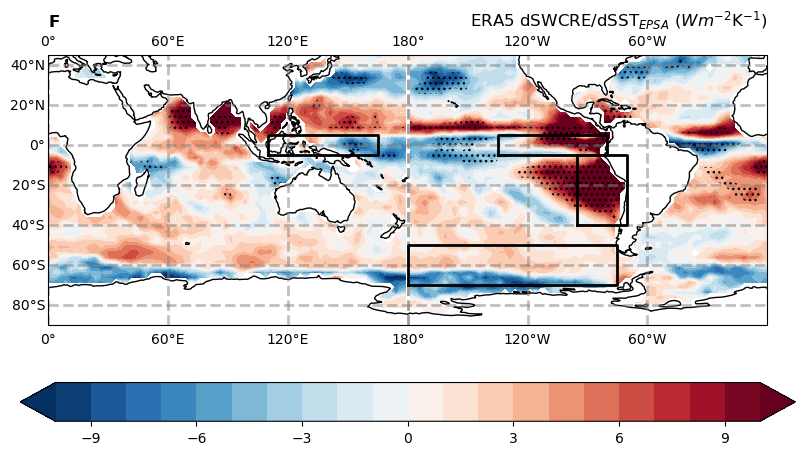

In [44]:
# global_plot(dsstwedcre, dsstwedcre.lon, dsstwedcre.lat, levels=np.arange(-.05, .055, .005), cmap="RdBu_r", title=r"Obs dSST$_{WE}$/dCRE (K/W/m2)")
global_plot(dsstwedcre, dsstwedcre.lon, dsstwedcre.lat, levels=np.arange(-10, 11, 1), pvalues=dsstwedcre_p, cmap="RdBu_r", left_title="F", right_title=r"ERA5 dSWCRE/dSST$_{EPSA}$ ($Wm^{-2}$K$^{-1}$)")

In [33]:
ds = fix_coords(dsstwedcre.to_dataset())
# westFB = ds.sel(lon=slice(-180, -125), lat=slice(-10,10)).spatial.average("fb")["fb"] # Observed definition 
# eastFB = ds.sel(lon=slice(-120, -70), lat=slice(-10, 10)).spatial.average("fb")["fb"] # Observed definition 

westFB = ds.sel(lon=slice(140, 180), lat=slice(-5,5)).spatial.average("fb")["fb"] # Observed definition 
eastFB = ds.sel(lon=slice(-110, -75), lat=slice(-30, 15)).spatial.average("fb")["fb"] # Observed definition 
eastFB = ds.sel(lon=slice(-110, -75), lat=slice(-30, 5)).spatial.average("fb")["fb"] # Observed definition 
westFB - eastFB
# westFB
eastFB


<xarray.DataArray 'fb' ()>
array(6.49866635)
Attributes:
    regrid_method:  bilinear

In [110]:
eastFB = ds.sel(lon=slice(-120, -80), lat=slice(-20, 10)).spatial.average("fb")["fb"] # Observed definition 
westFB = ds.sel(lon=slice(140, 180), lat=slice(-5, 5)).spatial.average("fb")["fb"] # Observed definition 
westFB - eastFB
eastFB

<xarray.DataArray 'fb' ()>
array(-0.01325601)
Attributes:
    regrid_method:  bilinear